In [52]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import numpy as np

import os
import torch

# 设置要使用的显卡号
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # 在这里将'0'替换为你想要使用的显卡号

# 检查CUDA是否可用
if torch.cuda.is_available():
    # 设置设备
    device = torch.device("cuda")
    print("使用的CUDA设备:", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")
    print("CUDA不可用，使用CPU设备")



使用的CUDA设备: NVIDIA GeForce RTX 3090


In [53]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [54]:
np.random.seed = 42

NUM_QUBITS = 4
NUM_SHOTS = 10000
SHIFT = np.pi/2
LEARNING_RATE = 0.01
MOMENTUM = 0.5

# MNISY & FashionMNIST

In [73]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)
batch_size = 64

n_samples = 1024  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# 创建一个索引列表，包含所有类别（0-9）的样本
idx = []
for label in range(2):  # 遍历所有类别（0-9）
    label_idx = np.where(X_train.targets == label)[0][:n_samples]  # 获取当前类别的样本索引
    idx.append(label_idx)

# 将所有类别的索引合并为一个数组
idx = np.concatenate(idx)

# 根据索引过滤数据
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

In [74]:
# Use pre-defined torchvision function to load MNIST test data for validation
n_samples = 256
# 
X_val = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# 创建一个索引列表，包含所有类别（0-9）的样本
idx = []
for label in range(2):  # 遍历所有类别（0-9）
    label_idx = np.where(X_val.targets == label)[0][:n_samples]  # 获取当前类别的样本索引
    idx.append(label_idx)

# 将所有类别的索引合并为一个数组
idx = np.concatenate(idx)

# 根据索引过滤数据
X_val.data = X_val.data[idx]
X_val.targets = X_val.targets[idx]

# Define torch dataloader with filtered data
valid_loader = DataLoader(X_val, batch_size=batch_size, shuffle=False)

In [75]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 512

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# 创建一个索引列表，包含所有类别（0-9）的样本
idx = []
for label in range(2):  # 遍历所有类别（0-9）
    label_idx = np.where(X_test.targets == label)[0][:n_samples]  # 获取当前类别的样本索引
    idx.append(label_idx)

# 将所有类别的索引合并为一个数组
idx = np.concatenate(idx)

# 根据索引过滤数据
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

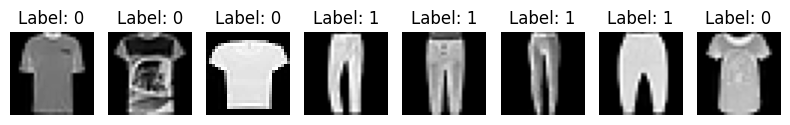

训练集大小: 2048
验证集大小: 512
测试集大小: 1024


In [76]:
# 从train_loader中获取4个批次的图像和标签
data_iter = iter(train_loader)
images, labels = [], []

for i in range(4):
    X, y = next(data_iter)
    images.append(X)
    labels.append(y)

images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)

# 展示图像
fig, axes = plt.subplots(1, 8, figsize=(8, 8))
axes = axes.ravel()
for i in range(8):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# 训练集大小
train_size = len(train_loader.dataset)
print("训练集大小:", train_size)

# 验证集大小
valid_size = len(valid_loader.dataset)
print("验证集大小:", valid_size)

# 测试集大小
test_size = len(test_loader.dataset)
print("测试集大小:", test_size)



# CIFAR10

In [77]:
# # Set random seed for reproducibility
# manual_seed(42)

# # Hyperparameters
# batch_size = 64
# n_samples = 1024  # Number of samples per class

# # Load MNIST dataset
# X_train = datasets.CIFAR10(
#     root="./data", 
#     train=True, 
#     download=True, 
#     transform=transforms.Compose([transforms.ToTensor()])
# )

# # Convert targets to NumPy array for easier indexing
# targets_np = np.array(X_train.targets)

# # Filter indices for labels 0 and 1
# label_0_idx = np.where(targets_np == 0)[0][:n_samples]  # Indices for label 0
# label_1_idx = np.where(targets_np == 1)[0][:n_samples]  # Indices for label 1

# # Combine indices
# idx = np.concatenate([label_0_idx, label_1_idx])

# # Filter data and targets
# X_train.data = X_train.data[idx]
# X_train.targets = targets_np[idx].tolist()  # Convert back to list for compatibility

# # Create DataLoader
# train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

In [78]:
# # Set random seed for reproducibility
# manual_seed(42)

# # Hyperparameters
# batch_size = 64
# n_samples = 256  # Number of samples per class

# # Load MNIST dataset
# X_Val = datasets.CIFAR10(
#     root="./data", 
#     train=False, 
#     download=True, 
#     transform=transforms.Compose([transforms.ToTensor()])
# )

# # Convert targets to NumPy array for easier indexing
# targets_np = np.array(X_Val.targets)

# # Filter indices for labels 0 and 1
# label_0_idx = np.where(targets_np == 0)[0][:n_samples]  # Indices for label 0
# label_1_idx = np.where(targets_np == 1)[0][:n_samples]  # Indices for label 1

# # Combine indices
# idx = np.concatenate([label_0_idx, label_1_idx])

# # Filter data and targets
# X_Val.data = X_Val.data[idx]
# X_Val.targets = targets_np[idx].tolist()  # Convert back to list for compatibility

# # Create DataLoader
# valid_loader = DataLoader(X_Val, batch_size=batch_size, shuffle=True)

In [79]:
# # Set random seed for reproducibility
# manual_seed(42)

# # Hyperparameters
# batch_size = 64
# n_samples = 512  # Number of samples per class

# # Load MNIST dataset
# X_test = datasets.CIFAR10(
#     root="./data", 
#     train=False, 
#     download=True, 
#     transform=transforms.Compose([transforms.ToTensor()])
# )

# # Convert targets to NumPy array for easier indexing
# targets_np = np.array(X_test.targets)

# # Filter indices for labels 0 and 1
# label_0_idx = np.where(targets_np == 0)[0][:n_samples]  # Indices for label 0
# label_1_idx = np.where(targets_np == 1)[0][:n_samples]  # Indices for label 1

# # Combine indices
# idx = np.concatenate([label_0_idx, label_1_idx])

# # Filter data and targets
# X_test.data = X_test.data[idx]
# X_test.targets = targets_np[idx].tolist()  # Convert back to list for compatibility

# # Create DataLoader
# test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [80]:
# # 从 train_loader 中获取 4 个批次的图像和标签
# data_iter = iter(train_loader)
# images, labels = [], []

# for i in range(4):
#     X, y = next(data_iter)
#     images.append(X)
#     labels.append(y)

# images = torch.cat(images, dim=0)
# labels = torch.cat(labels, dim=0)

# # 展示图像
# fig, axes = plt.subplots(1, 8, figsize=(8, 8))
# axes = axes.ravel()
# for i in range(8):
#     # 调整图像形状：从 (3, 32, 32) 转换为 (32, 32, 3)
#     img = images[i].permute(1, 2, 0)  # 调整维度顺序
#     axes[i].imshow(img)
#     axes[i].set_title(f"Label: {labels[i]}")
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

# # 训练集大小
# train_size = len(train_loader.dataset)
# print("训练集大小:", train_size)

# # 验证集大小
# valid_size = len(valid_loader.dataset)
# print("验证集大小:", valid_size)

# # 测试集大小
# test_size = len(test_loader.dataset)
# print("测试集大小:", test_size)



In [81]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 32)  # 2-dimensional input to QNN
        self.cc = nn.Linear(32, 1)
        # uniformly at random from interval [-1,1].
        #self.fc3 = Linear(1, 2)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = np.pi*torch.tanh(x)
        x = self.cc(x)
        x = F.softmax(x)
        return x


model = Net().to(device)
#print(model)

In [82]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


  0%|          | 0/32 [00:00<?, ?it/s]C:\Users\ly\AppData\Local\Temp\ipykernel_31200\2666356519.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
100%|██████████| 32/32 [00:00<00:00, 119.40it/s]


Epoch : 1 - loss : 2.0541 - acc: 0.5776 - val_loss : 1.7896 - val_acc: 0.8242


100%|██████████| 32/32 [00:00<00:00, 127.70it/s]


Epoch : 2 - loss : 1.6699 - acc: 0.8989 - val_loss : 1.5920 - val_acc: 0.9199


100%|██████████| 32/32 [00:00<00:00, 137.34it/s]


Epoch : 3 - loss : 1.5694 - acc: 0.9248 - val_loss : 1.5558 - val_acc: 0.9258


100%|██████████| 32/32 [00:00<00:00, 134.29it/s]


Epoch : 4 - loss : 1.5427 - acc: 0.9321 - val_loss : 1.5395 - val_acc: 0.9297


100%|██████████| 32/32 [00:00<00:00, 114.47it/s]


Epoch : 5 - loss : 1.5346 - acc: 0.9351 - val_loss : 1.5363 - val_acc: 0.9297


100%|██████████| 32/32 [00:00<00:00, 131.69it/s]


Epoch : 6 - loss : 1.5271 - acc: 0.9395 - val_loss : 1.5252 - val_acc: 0.9375


100%|██████████| 32/32 [00:00<00:00, 140.26it/s]


Epoch : 7 - loss : 1.5186 - acc: 0.9502 - val_loss : 1.5232 - val_acc: 0.9395


100%|██████████| 32/32 [00:00<00:00, 129.89it/s]


Epoch : 8 - loss : 1.5170 - acc: 0.9473 - val_loss : 1.5177 - val_acc: 0.9492


100%|██████████| 32/32 [00:00<00:00, 136.42it/s]


Epoch : 9 - loss : 1.5102 - acc: 0.9546 - val_loss : 1.5147 - val_acc: 0.9453


100%|██████████| 32/32 [00:00<00:00, 134.13it/s]


Epoch : 10 - loss : 1.5053 - acc: 0.9590 - val_loss : 1.5001 - val_acc: 0.9629


100%|██████████| 32/32 [00:00<00:00, 133.66it/s]


Epoch : 11 - loss : 1.5088 - acc: 0.9541 - val_loss : 1.5087 - val_acc: 0.9512


100%|██████████| 32/32 [00:00<00:00, 133.02it/s]


Epoch : 12 - loss : 1.4994 - acc: 0.9639 - val_loss : 1.4965 - val_acc: 0.9688


100%|██████████| 32/32 [00:00<00:00, 114.70it/s]


Epoch : 13 - loss : 1.4933 - acc: 0.9712 - val_loss : 1.4960 - val_acc: 0.9668


100%|██████████| 32/32 [00:00<00:00, 127.69it/s]


Epoch : 14 - loss : 1.4921 - acc: 0.9722 - val_loss : 1.4962 - val_acc: 0.9648


100%|██████████| 32/32 [00:00<00:00, 133.58it/s]


Epoch : 15 - loss : 1.4904 - acc: 0.9741 - val_loss : 1.4970 - val_acc: 0.9648


100%|██████████| 32/32 [00:00<00:00, 136.31it/s]


Epoch : 16 - loss : 1.4843 - acc: 0.9790 - val_loss : 1.4882 - val_acc: 0.9707


100%|██████████| 32/32 [00:00<00:00, 129.83it/s]


Epoch : 17 - loss : 1.4839 - acc: 0.9785 - val_loss : 1.4948 - val_acc: 0.9688


100%|██████████| 32/32 [00:00<00:00, 124.51it/s]


Epoch : 18 - loss : 1.4804 - acc: 0.9819 - val_loss : 1.4920 - val_acc: 0.9707


100%|██████████| 32/32 [00:00<00:00, 134.69it/s]


Epoch : 19 - loss : 1.4822 - acc: 0.9800 - val_loss : 1.4935 - val_acc: 0.9688


100%|██████████| 32/32 [00:00<00:00, 128.18it/s]


Epoch : 20 - loss : 1.4791 - acc: 0.9839 - val_loss : 1.4898 - val_acc: 0.9707


100%|██████████| 32/32 [00:00<00:00, 117.82it/s]


Epoch : 21 - loss : 1.4806 - acc: 0.9814 - val_loss : 1.4850 - val_acc: 0.9766


100%|██████████| 32/32 [00:00<00:00, 138.62it/s]


Epoch : 22 - loss : 1.4777 - acc: 0.9849 - val_loss : 1.4844 - val_acc: 0.9766


100%|██████████| 32/32 [00:00<00:00, 131.69it/s]


Epoch : 23 - loss : 1.4762 - acc: 0.9858 - val_loss : 1.4907 - val_acc: 0.9707


100%|██████████| 32/32 [00:00<00:00, 140.59it/s]


Epoch : 24 - loss : 1.4758 - acc: 0.9858 - val_loss : 1.4840 - val_acc: 0.9785


100%|██████████| 32/32 [00:00<00:00, 134.59it/s]


Epoch : 25 - loss : 1.4755 - acc: 0.9868 - val_loss : 1.4831 - val_acc: 0.9766


100%|██████████| 32/32 [00:00<00:00, 139.74it/s]


Epoch : 26 - loss : 1.4795 - acc: 0.9819 - val_loss : 1.4795 - val_acc: 0.9824


100%|██████████| 32/32 [00:00<00:00, 130.79it/s]


Epoch : 27 - loss : 1.4750 - acc: 0.9878 - val_loss : 1.4842 - val_acc: 0.9766


100%|██████████| 32/32 [00:00<00:00, 129.55it/s]


Epoch : 28 - loss : 1.4766 - acc: 0.9849 - val_loss : 1.4853 - val_acc: 0.9766


100%|██████████| 32/32 [00:00<00:00, 139.36it/s]


Epoch : 29 - loss : 1.4746 - acc: 0.9868 - val_loss : 1.4819 - val_acc: 0.9785


100%|██████████| 32/32 [00:00<00:00, 119.85it/s]


Epoch : 30 - loss : 1.4745 - acc: 0.9873 - val_loss : 1.4861 - val_acc: 0.9746


100%|██████████| 32/32 [00:00<00:00, 131.91it/s]


Epoch : 31 - loss : 1.4735 - acc: 0.9878 - val_loss : 1.4799 - val_acc: 0.9824


100%|██████████| 32/32 [00:00<00:00, 139.92it/s]


Epoch : 32 - loss : 1.4729 - acc: 0.9893 - val_loss : 1.4844 - val_acc: 0.9785


100%|██████████| 32/32 [00:00<00:00, 140.97it/s]


Epoch : 33 - loss : 1.4756 - acc: 0.9863 - val_loss : 1.4793 - val_acc: 0.9805


100%|██████████| 32/32 [00:00<00:00, 140.01it/s]


Epoch : 34 - loss : 1.4727 - acc: 0.9883 - val_loss : 1.4808 - val_acc: 0.9805


100%|██████████| 32/32 [00:00<00:00, 135.59it/s]


Epoch : 35 - loss : 1.4710 - acc: 0.9907 - val_loss : 1.4842 - val_acc: 0.9785


100%|██████████| 32/32 [00:00<00:00, 129.00it/s]


Epoch : 36 - loss : 1.4701 - acc: 0.9922 - val_loss : 1.4867 - val_acc: 0.9746


100%|██████████| 32/32 [00:00<00:00, 137.34it/s]


Epoch : 37 - loss : 1.4714 - acc: 0.9902 - val_loss : 1.4850 - val_acc: 0.9746


100%|██████████| 32/32 [00:00<00:00, 132.78it/s]


Epoch : 38 - loss : 1.4742 - acc: 0.9868 - val_loss : 1.4785 - val_acc: 0.9844


100%|██████████| 32/32 [00:00<00:00, 117.41it/s]


Epoch : 39 - loss : 1.4725 - acc: 0.9893 - val_loss : 1.4812 - val_acc: 0.9805


100%|██████████| 32/32 [00:00<00:00, 133.33it/s]


Epoch : 40 - loss : 1.4713 - acc: 0.9902 - val_loss : 1.4813 - val_acc: 0.9785


100%|██████████| 32/32 [00:00<00:00, 133.25it/s]


Epoch : 41 - loss : 1.4730 - acc: 0.9878 - val_loss : 1.4790 - val_acc: 0.9824


100%|██████████| 32/32 [00:00<00:00, 132.38it/s]


Epoch : 42 - loss : 1.4694 - acc: 0.9922 - val_loss : 1.4799 - val_acc: 0.9805


100%|██████████| 32/32 [00:00<00:00, 136.75it/s]


Epoch : 43 - loss : 1.4700 - acc: 0.9912 - val_loss : 1.4815 - val_acc: 0.9805


100%|██████████| 32/32 [00:00<00:00, 134.72it/s]


Epoch : 44 - loss : 1.4704 - acc: 0.9917 - val_loss : 1.4768 - val_acc: 0.9844


100%|██████████| 32/32 [00:00<00:00, 134.45it/s]


Epoch : 45 - loss : 1.4710 - acc: 0.9902 - val_loss : 1.4824 - val_acc: 0.9805


100%|██████████| 32/32 [00:00<00:00, 130.30it/s]


Epoch : 46 - loss : 1.4739 - acc: 0.9868 - val_loss : 1.4793 - val_acc: 0.9844


100%|██████████| 32/32 [00:00<00:00, 132.23it/s]


Epoch : 47 - loss : 1.4700 - acc: 0.9912 - val_loss : 1.4792 - val_acc: 0.9824


100%|██████████| 32/32 [00:00<00:00, 127.70it/s]


Epoch : 48 - loss : 1.4696 - acc: 0.9922 - val_loss : 1.4779 - val_acc: 0.9844


100%|██████████| 32/32 [00:00<00:00, 131.92it/s]


Epoch : 49 - loss : 1.4707 - acc: 0.9902 - val_loss : 1.4828 - val_acc: 0.9805


100%|██████████| 32/32 [00:00<00:00, 130.85it/s]


Epoch : 50 - loss : 1.4705 - acc: 0.9912 - val_loss : 1.4847 - val_acc: 0.9766


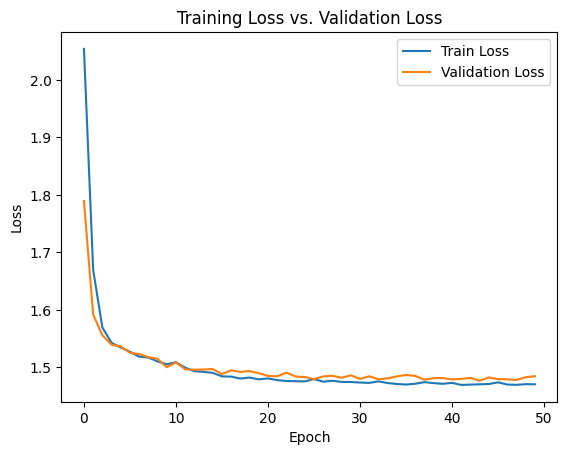

In [83]:
import logging

# 设置日志记录器
log_file = "training_CC.log"
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(message)s')

# 开始训练
epochs = 50
model.train()

train_losses = []
val_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    train_losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)
    
    log_message = f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}"
    logging.info(log_message)  # 将训练日志记录到文件中

    if epoch % 1 == 0:
        print(log_message)
        
    torch.save(model.state_dict(), "model_CC.pt")

# 将列表转换为张量
train_losses_tensor = torch.Tensor(train_losses)
val_losses_tensor = torch.Tensor(val_losses)

# 绘制损失曲线
plt.plot(train_losses_tensor.cpu().numpy(), label='Train Loss')
plt.plot(val_losses_tensor.cpu().numpy(), label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Validation Loss')
plt.savefig('./loss_image_CC.png')
plt.show()

In [84]:
model = Net().to(device)
model.load_state_dict(torch.load("model_CC.pt"))


<All keys matched successfully>

In [85]:
model.eval()  # set model to evaluation mode
with no_grad():
    total_loss = []
    correct = 0
    all_ = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        all_ += len(target)

        loss = criterion(output, target)
        total_loss.append(loss.item())
    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / all_ * 100
        )
    )


Performance on test data:
	Loss: 1.4766
	Accuracy: 98.4%


C:\Users\ly\AppData\Local\Temp\ipykernel_31200\2666356519.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


C:\Users\ly\AppData\Local\Temp\ipykernel_31200\2666356519.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


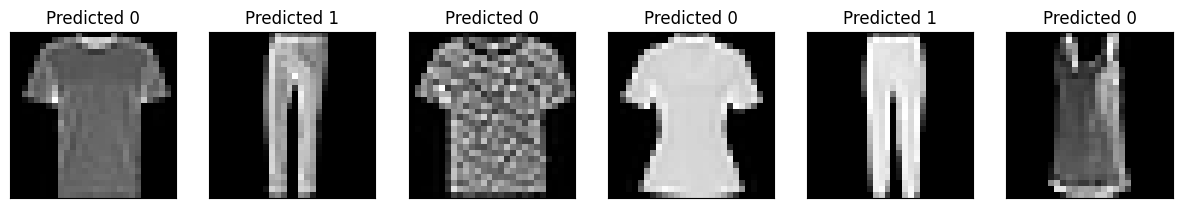

In [86]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(15, 8))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)

        for i in range(data.shape[0]):
            if count == n_samples_show:
                break

            output = model(data[i:i+1])  # 处理单个数据样本
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)

            pred = output.argmax(dim=1, keepdim=True)

            axes[count].imshow(data[i].cpu().numpy().squeeze(), cmap="gray")
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title("Predicted {}".format(pred.item()))

            count += 1

        if count == n_samples_show:
            break
